# Objective
Reproduce the DICE scores reported in the MicroSplit paper.

In [1]:
rootinputdir = './data/raw_data/' # should contain GT.tif and the prediction pred_disentangle_2404_D21-M3-S0-L8_6_1.tif
rootsegmentationdir = './data/seg/' # the segmenetation output directory.
# OUTPUT_DIR = '/group/jug/ashesh/naturemethods/segmentation/three_analysts/2404_D21-M3-S0-L8_6/' # the output directory for the final results

In [2]:
import pooch
import os

RAW_DATA = pooch.create(
    path=rootinputdir,
    base_url=f"https://download.fht.org/jug/msplit/segmentation_data/",
    registry={"HTT24_raw.zip": None},
)

SEGMENTED_DATA = pooch.create(
    path=rootsegmentationdir,
    base_url=f"https://download.fht.org/jug/msplit/segmentation_data/",
    registry={"HTT24_seg.zip": None},
)
for fname in RAW_DATA.registry:
    RAW_DATA.fetch(fname, processor=pooch.Unzip(), progressbar=True)
    inputdir = os.path.join(rootinputdir, fname +'.unzip')

for fname in SEGMENTED_DATA.registry:
    SEGMENTED_DATA.fetch(fname, processor=pooch.Unzip(), progressbar=True)
    segmentationdir = os.path.join(rootsegmentationdir, fname +'.unzip', 'HTT24')

100%|████████████████████████████████████████| 111M/111M [00:00<00:00, 136GB/s]
Unzipping contents of '/home/ashesh.ashesh/code/microSplit-reproducibility/examples/segmentation_results/data/raw_data/HTT24_raw.zip' to '/home/ashesh.ashesh/code/microSplit-reproducibility/examples/segmentation_results/data/raw_data/HTT24_raw.zip.unzip'
100%|████████████████████████████████████████| 346M/346M [00:00<00:00, 599GB/s]
Unzipping contents of '/home/ashesh.ashesh/code/microSplit-reproducibility/examples/segmentation_results/data/seg/HTT24_seg.zip' to '/home/ashesh.ashesh/code/microSplit-reproducibility/examples/segmentation_results/data/seg/HTT24_seg.zip.unzip'


In [3]:
import matplotlib.pyplot as plt
import os
from collections import defaultdict
import numpy as np
import pandas as pd
# import seaborn as sns
from skimage.io import imread


def load_tiff(path):
    """
    Returns a 4d numpy array: num_imgs*h*w*num_channels
    """
    data = imread(path, plugin='tifffile')
    return data

def clean_ax(ax):
    # 2D or 1D axes are of type np.ndarray
    if isinstance(ax, np.ndarray):
        for one_ax in ax:
            clean_ax(one_ax)
        return

    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.tick_params(left=False, right=False, top=False, bottom=False)


In [4]:
ch_idx = 0 # which channel are we interested in doing segmentation.
crop_size = 1600 # because the prediction is for top left 1600x1600, we need to crop the GT to match the size.
gt = load_tiff(os.path.join(inputdir, 'GT_HTT24.tif'))[:,:crop_size, :crop_size,:]
pred  = load_tiff(os.path.join(inputdir, 'pred_HTT24.tif'))
pred = pred[...,:crop_size, :crop_size]
pred.shape, gt.shape

((5, 2, 1600, 1600), (5, 1600, 1600, 3))

In [5]:
input = gt[...,2]
gt_ch = gt[...,ch_idx]
pred_ch = pred[:,ch_idx]
raw_dict = {'input':input, 'pred':pred_ch, 'GT':gt_ch}


In [6]:
def load_segmentation():
    # 2 level nested dictionary
    segmentation = defaultdict(lambda: defaultdict(list))
    for analystdir in os.listdir(segmentationdir):
        if os.path.isdir(os.path.join(segmentationdir,analystdir)):
            for subdir in [f'gt_ch{ch_idx+1}','superimposed',f'pred_ch{ch_idx+1}']:
                fpath = os.path.join(segmentationdir, analystdir, subdir, 'Seg.tif')
                print(analystdir, subdir, fpath)
                assert os.path.exists(fpath), f'File {fpath} does not exist'
                if subdir.startswith('gt_ch'):
                    key = 'GT'
                elif subdir.startswith('pred_ch'):
                    key = 'pred'
                elif subdir.startswith('superimposed'):
                    key = 'input'
                else:
                    raise ValueError(f'Unknown subdir {subdir}')
                segmentation[analystdir][key].append(load_tiff(fpath)[..., :crop_size, :crop_size])
                if key == 'input':
                    if analystdir != 'data_JD':
                        segmentation[analystdir][key][-1] = segmentation[analystdir][key][-1] == ch_idx + 1
                    else:
                        segmentation[analystdir][key][-1] = segmentation[analystdir][key][-1] == (2*(ch_idx + 1) %3)
                print(analystdir, key, segmentation[analystdir][key][-1].shape)
    return segmentation

In [7]:
seg_data = load_segmentation()
# seg_data['data_JD']['input'][0] = seg_data['data_JD']['input'][0][None]
analysts  = list(seg_data.keys())
analysts

data_DDN gt_ch1 ./data/seg/HTT24_seg.zip.unzip/HTT24/data_DDN/gt_ch1/Seg.tif
data_DDN GT (5, 1600, 1600)
data_DDN superimposed ./data/seg/HTT24_seg.zip.unzip/HTT24/data_DDN/superimposed/Seg.tif
data_DDN input (5, 1600, 1600)
data_DDN pred_ch1 ./data/seg/HTT24_seg.zip.unzip/HTT24/data_DDN/pred_ch1/Seg.tif
data_DDN pred (5, 1600, 1600)
data_JD gt_ch1 ./data/seg/HTT24_seg.zip.unzip/HTT24/data_JD/gt_ch1/Seg.tif
data_JD GT (5, 1600, 1600)
data_JD superimposed ./data/seg/HTT24_seg.zip.unzip/HTT24/data_JD/superimposed/Seg.tif
data_JD input (5, 1600, 1600)
data_JD pred_ch1 ./data/seg/HTT24_seg.zip.unzip/HTT24/data_JD/pred_ch1/Seg.tif
data_JD pred (5, 1600, 1600)
data_JMB gt_ch1 ./data/seg/HTT24_seg.zip.unzip/HTT24/data_JMB/gt_ch1/Seg.tif
data_JMB GT (5, 1600, 1600)
data_JMB superimposed ./data/seg/HTT24_seg.zip.unzip/HTT24/data_JMB/superimposed/Seg.tif
data_JMB input (5, 1600, 1600)
data_JMB pred_ch1 ./data/seg/HTT24_seg.zip.unzip/HTT24/data_JMB/pred_ch1/Seg.tif
data_JMB pred (5, 1600, 1600)


['data_DDN', 'data_JD', 'data_JMB']

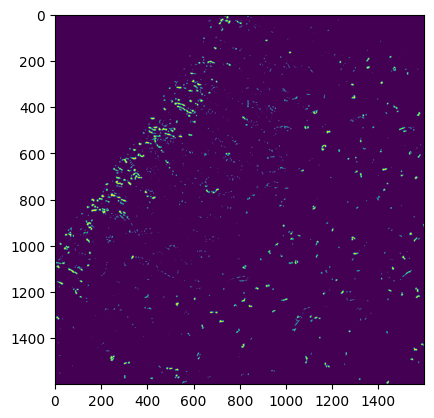

In [8]:
plt.imshow(seg_data['data_JD']['input'][0][0])

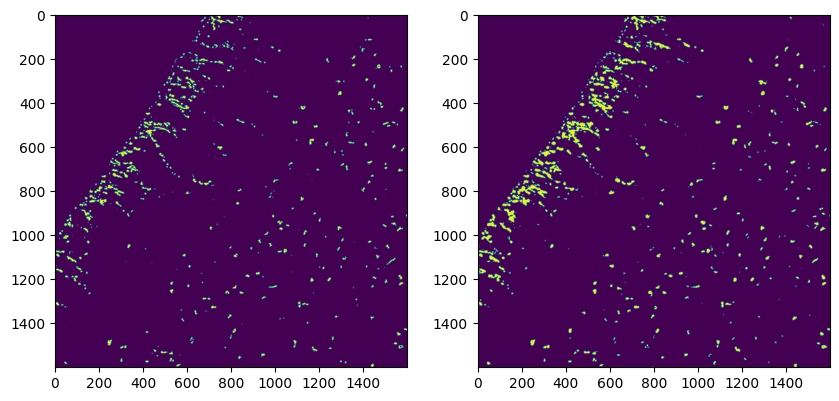

In [9]:
_,ax = plt.subplots(figsize=(10,5),ncols=2)
i = 0
ax[0].imshow(seg_data['data_JD']['GT'][0][i])
ax[1].imshow(seg_data['data_JMB']['GT'][0][i]
             )

## Single reviewer prediction

In [10]:
def dice_coefficient(x,y):
    assert set(np.unique(x)) == set([0,1])
    assert set(np.unique(y)) == set([0,1])
    intersection = np.sum(x[y==1])
    union = np.sum(x) + np.sum(y)
    return 2*intersection/union

def add_text(ax, text, img_shape, place='TOP_LEFT'):
    """
    Adding text on image
    """
    assert place in ['TOP_LEFT', 'BOTTOM_RIGHT']
    if place == 'TOP_LEFT':
        ax.text(20, 40, text, bbox=dict(facecolor='white', alpha=0.9))
    elif place == 'BOTTOM_RIGHT':
        s0 = img_shape[1]
        s1 = img_shape[0]
        ax.text(s0 - s0 * 150 / 500, s1 - s1 * 35 / 500, text, bbox=dict(facecolor='white', alpha=0.9))


In [11]:
seg_data['data_JD']['GT'][0].shape

(5, 1600, 1600)

In [12]:
for analyst in analysts:
    dice_gt_input = [dice_coefficient(seg_data[analyst]['GT'][0][idx], seg_data[analyst]['input'][0][idx]) for idx in range(len(seg_data[analyst]['GT'][0]))]
    dice_gt_pred  = [dice_coefficient(seg_data[analyst]['GT'][0][idx], seg_data[analyst]['pred'][0][idx]) for idx in range(len(seg_data[analyst]['GT'][0]))]
    print('GT vs Input', analyst, dice_gt_input)
    print('GT vs Pred', analyst, dice_gt_pred)


GT vs Input data_DDN [0.5562507884445566, 0.49834842834310067, 0.44786996403732515, 0.4178750160400359, 0.5015249863142254]
GT vs Pred data_DDN [0.778184352674682, 0.7526561003222154, 0.69954324195046, 0.5911474102408838, 0.6788002866209438]
GT vs Input data_JD [0.5892076785431705, 0.5942583033018408, 0.6053060217176703, 0.5857894467998161, 0.5728568261071133]
GT vs Pred data_JD [0.8151098876056261, 0.7943745831367637, 0.7674278846153846, 0.7623930627979919, 0.7670516703324544]
GT vs Input data_JMB [0.36911562336029463, 0.2802964746604462, 0.15739229147521488, 0.0950712342662179, 0.10189132144187393]
GT vs Pred data_JMB [0.5020840950639853, 0.5407864601529444, 0.6151927405134968, 0.4904745619505522, 0.6398196887348254]


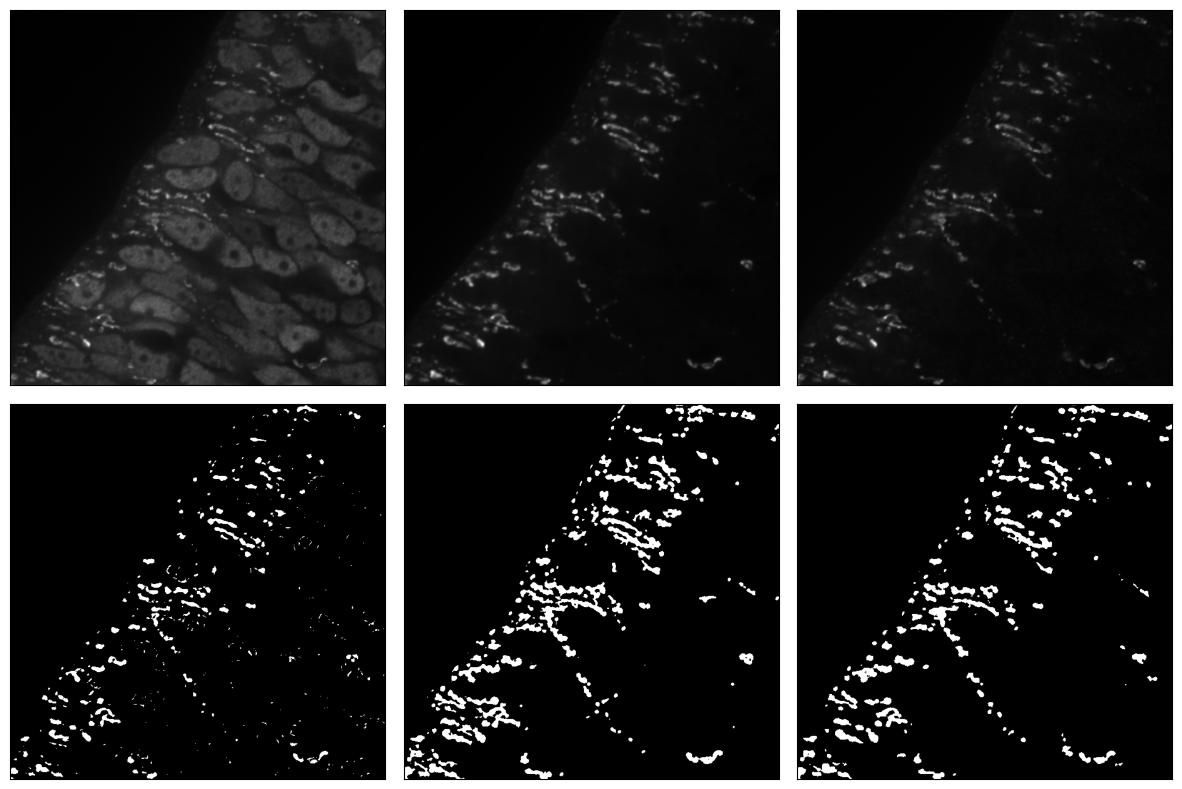

In [13]:
img_idx = 0
reviewer_key = 'data_JD'
seg_input = seg_data[reviewer_key]['input'][0][img_idx]
seg_pred = seg_data[reviewer_key]['pred'][0][img_idx]
seg_GT = seg_data[reviewer_key]['GT'][0][img_idx]

img_size = 5
hs = 200
he = 800

ws = 200
we = 800
save_to_file = False

_,ax = plt.subplots(figsize=(3*img_size, 2*img_size), ncols=3,nrows=2)
ax[0,0].imshow(raw_dict['input'][img_idx][hs:he,ws:we], cmap='gray')
ax[0,1].imshow(raw_dict['pred'][img_idx][hs:he,ws:we], cmap='gray')
ax[0,2].imshow(raw_dict['GT'][img_idx][hs:he,ws:we], cmap='gray')
ax[1,0].imshow(seg_input[hs:he,ws:we], cmap='gray')
ax[1,1].imshow(seg_pred[hs:he,ws:we], cmap='gray')
ax[1,2].imshow(seg_GT[hs:he,ws:we], cmap='gray')

# dice_input = dice_coefficient(seg_GT.flatten() > 0, seg_input.flatten() >0)
# dice_pred = dice_coefficient(seg_GT.flatten() > 0, seg_pred.flatten() >0)
# add_text(ax[1,0], f'DICE: {dice_input:.2f}', seg_input.shape, place='TOP_LEFT')
# add_text(ax[1,1], f'DICE: {dice_pred:.2f}', seg_input.shape, place='TOP_LEFT')


clean_ax(ax)
# remove the space between the subplots
plt.subplots_adjust(wspace=0.05, hspace=0.05)
if save_to_file:
    OneAnalyst_OUTPUT_DIR = OUTPUT_DIR.replace('three_analysts', 'one_analyst')
    model_token = os.path.basename(inputdir.strip('/'))
    fname = f'segmentation_1analyst_reviewer:{reviewer_key}_Imgidx:{img_idx}_{model_token}_{hs}-{he}-{ws}-{we}.png'
    fpath = os.path.join(OneAnalyst_OUTPUT_DIR, fname)
    print(fpath)
    plt.savefig(fpath, dpi = 100, bbox_inches='tight')


In [14]:
dice_score_dict= {}
reviewers = ['data_DDN','data_JMB', 'data_JD']
for review in reviewers:
    reviewer_seg = seg_data[review]
    gt_seg = reviewer_seg['GT'][0]
    pred_seg = reviewer_seg['pred'][0]
    input_seg = reviewer_seg['input'][0]
    dice_scores_pred = [dice_coefficient(gt.flatten() > 0, pred.flatten() > 0) for gt, pred in zip(gt_seg, pred_seg)]
    dice_scores_input = [dice_coefficient(gt.flatten() > 0, input.flatten() > 0) for gt, input in zip(gt_seg, input_seg)]

    dice_score_dict[review] = {'pred':dice_scores_pred, 
                               'input':dice_scores_input}

In [15]:
pred_df = pd.DataFrame.from_dict({r:dice_score_dict[r]['pred'] for r in reviewers})
avg_pred = pred_df.mean(axis=0)
stderr_pred = pred_df.std(axis=0)/np.sqrt(pred_df.shape[0])

inp_df = pd.DataFrame.from_dict({r:dice_score_dict[r]['input'] for r in reviewers})
avg_inp = inp_df.mean(axis=0)
stderr_inp = inp_df.std(axis=0)/np.sqrt(inp_df.shape[0])

In [16]:
dice_GT_score_dict= {}
for i1,an1 in enumerate(analysts):
    for i2,an2 in enumerate(analysts[i1+1:]):
        if an1 == an2:
            continue
        
        assert len(seg_data[an1]['GT']) == 1
        gt_seg1 = seg_data[an1]['GT'][0]
        gt_seg2 = seg_data[an2]['GT'][0]
        print(an1, an2)
        dice_GT_score_dict[f'A{i1}-A{i1+i2+1}'] = [dice_coefficient(gt1.flatten() > 0, gt2.flatten() > 0) for gt1, gt2 in zip(gt_seg1, gt_seg2)]
inter_reviewer_variability_df = pd.DataFrame.from_dict(dice_GT_score_dict)

data_DDN data_JD
data_DDN data_JMB
data_JD data_JMB


# Results.
Below one has the DICE scores for the five frames, for each of the three reviewers.

In [17]:
pred_df.columns = [f'A{i}' for i in range(3)]
pred_df

,A0,A1,A2
0,0.778184,0.502084,0.815110
1,0.752656,0.540786,0.794375
2,0.699543,0.615193,0.767428
3,0.591147,0.490475,0.762393
4,0.678800,0.639820,0.767052


/tmp/ipykernel_45921/1057923419.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bp = sns.boxplot(data=pd.concat([df, variability_df], axis=1), ax=ax, color='0.95', palette=colors)


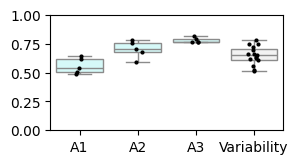

In [18]:
import seaborn as sns
save_to_file = False

df = pred_df[['A1','A0','A2']].copy()
df.columns = ['A1', 'A2', 'A3']
variability_df = pd.Series(inter_reviewer_variability_df.values.reshape(-1,)).to_frame('Variability')

# Create a figure and axis
fig, ax = plt.subplots(figsize=(3, 1.5))

# Create the boxplot
colors = ['#D0FFFD', '#D0FFFD', '#D0FFFD', '0.95']
bp = sns.boxplot(data=pd.concat([df, variability_df], axis=1), ax=ax, color='0.95', palette=colors)

# Create the scatter plot (strip plot) on top of the boxplot
sns.stripplot(data=pd.concat([df, variability_df], axis=1), ax=ax, color='black', jitter=True, size=3)

plt.ylim(0.0,1.0)

# Show the plot
if save_to_file:
    model_token = os.path.basename(inputdir.strip('/'))
    fname = f'segmentation_3analyst_quantitative_{model_token}.png'
    fpath = os.path.join(OneAnalyst_OUTPUT_DIR, fname)
    print(fpath)
    plt.savefig(fpath, dpi = 200, bbox_inches='tight')